<a href="https://colab.research.google.com/github/dIcarusb/Master_project/blob/master/segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segnet model
Importing libraries

In [0]:

import numpy as np
import matplotlib.pyplot as plt
import time
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers.merge import *
from numpy.random import shuffle
from numpy.random import seed
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


## Loading the dataset

In [0]:
from google.colab import files

uploaded = files.upload()

In [0]:
y = np.load('y.npy')
x = np.load('x.npy')

Transforming "y" into 3 classes/3 dimensiones, with the help of dummy function:

In [0]:
def dummy(y):
  NewY = np.zeros(448*120*120*3)
  Y = np.reshape(NewY, (448,120,120,3))
  
  for i in range(0,447):
    for j in range(0,119):
      for k in range(0,119):
        if y[i][j][k]==0:
          Y[i][j][k][0]=1
        elif y[i][j][k]==128:
          Y[i][j][k][1]=1
        else:
          Y[i][j][k][2]=1
        
  return(Y)

In [0]:
y = dummy(y)

"x" scaling

In [0]:
x = x/255

Random shuffle

In [0]:
seed(2)
shuffle(x)
seed(2)
shuffle(y)

Test and train partition

In [0]:
X_test = x[418:]
Y_test = y[418:]
X_train = x[0:417]
Y_train= y[0:417]

##Model
SegNet-Basic; in the deconvolution layers, the activation function is not present as it suggested in the original paper.

In [0]:
def conv_block(tensor, nfilters, size=7, padding="same", initializer="glorot_uniform"):  
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
  
def deconv_block(tensor, nfilters, size=7, padding="same", initializer="glorot_uniform"):  
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    #x = Activation("relu")(x)
    return x

def Segnet(img_height,img_width,  nclasses=3,filters=64):
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    
    #encoder
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(3, 3))(conv4) # modification
    
    
    #decoder
    up1 = UpSampling2D(size=(3, 3))(conv4_out) # modification
    conv5 = deconv_block(up1, nfilters=filters*8)
    up2 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = deconv_block(up2, nfilters=filters*4)
    up3 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = deconv_block(up3, nfilters=filters*2)
    up4 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = deconv_block(up4, nfilters=filters)
    
    
    #output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(conv8)
    output_laye = Dropout(0.5)(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Segnet')
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model
	

Building the model

In [0]:
m = Segnet(120, 120, nclasses=3, filters=64)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 120, 120, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       401536    
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 128)       512       
__________

##Training the model

In [0]:
start=time.time()
history = m.fit(X_train, Y_train,epochs=30, batch_size=20, verbose=1, validation_data=(X_test, Y_test))
end=time.time()
print("Time:")
print(end-start)

Train on 417 samples, validate on 30 samples
Epoch 1/30
417/417 [==============================] - 41s 98ms/step - loss: 0.2756 - acc: 0.8865 - val_loss: 0.2800 - val_acc: 0.9114
Epoch 2/30
417/417 [==============================] - 24s 57ms/step - loss: 0.1468 - acc: 0.9381 - val_loss: 0.1951 - val_acc: 0.9216
Epoch 3/30
417/417 [==============================] - 24s 57ms/step - loss: 0.1176 - acc: 0.9521 - val_loss: 0.1224 - val_acc: 0.9459
Epoch 4/30
417/417 [==============================] - 24s 57ms/step - loss: 0.1052 - acc: 0.9574 - val_loss: 0.1240 - val_acc: 0.9489
Epoch 5/30
417/417 [==============================] - 24s 57ms/step - loss: 0.0951 - acc: 0.9627 - val_loss: 0.1412 - val_acc: 0.9366
Epoch 6/30
417/417 [==============================] - 24s 57ms/step - loss: 0.0864 - acc: 0.9681 - val_loss: 0.1212 - val_acc: 0.9469
Epoch 7/30
417/417 [==============================] - 24s 57ms/step - loss: 0.0804 - acc: 0.9713 - val_loss: 0.0969 - val_acc: 0.9582
Epoch 8/30
417/41

##Evaluation of the model

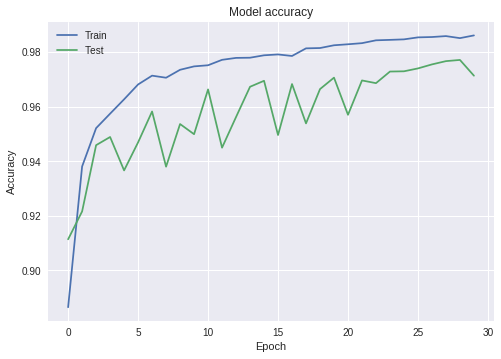

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('SegNet_accuracy.png')
plt.show()

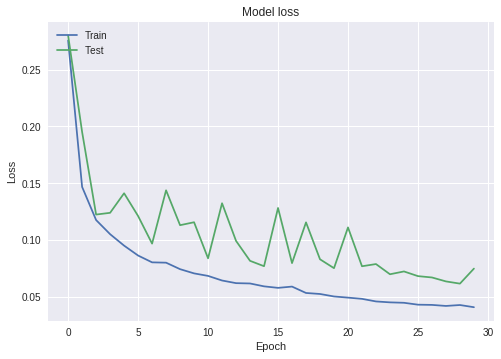

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('SegNet_loss.png')
plt.show()

Accuracy on test data

In [0]:
score = m.evaluate(X_test, Y_test)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

30/30 [==============================] - 4s 120ms/step

Test loss: 0.07491198182106018
Test accuracy: 0.9713271856307983


Prediction on test data

In [0]:
prediction = m.predict(X_test,verbose=1)
p = np.reshape(prediction, (30,120,120,3))
p = p.round()

30/30 [==============================] - 0s 16ms/step


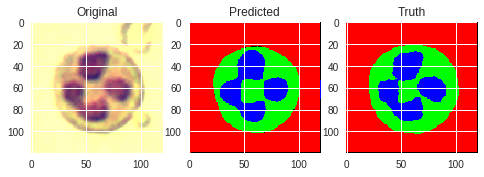

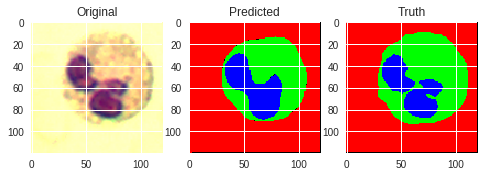

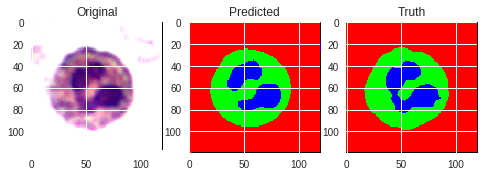

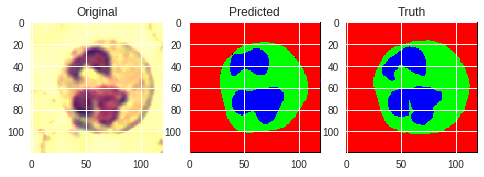

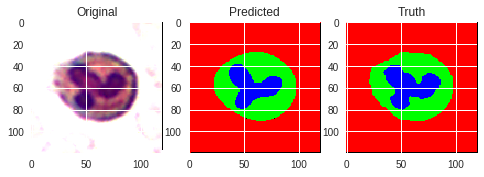

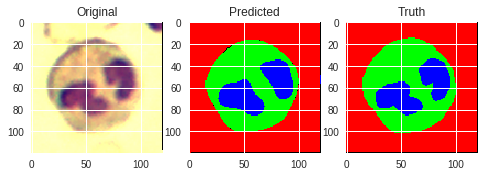

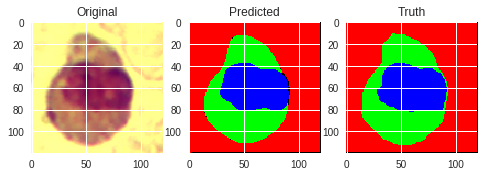

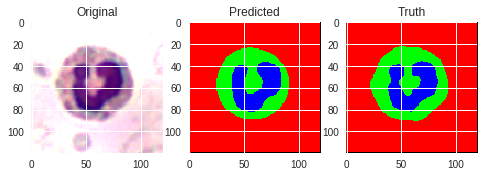

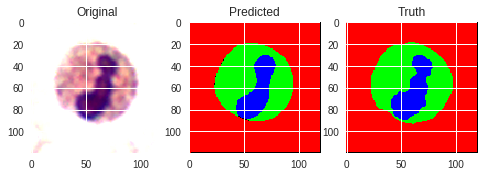

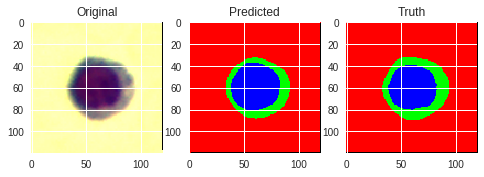

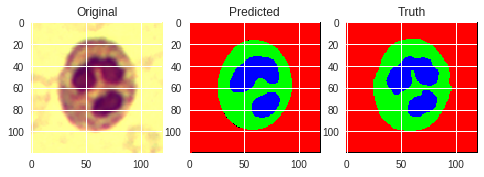

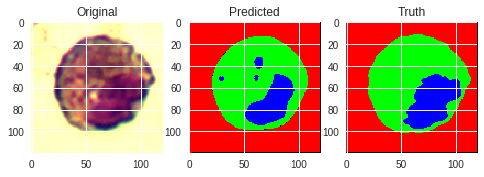

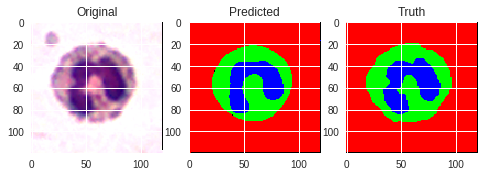

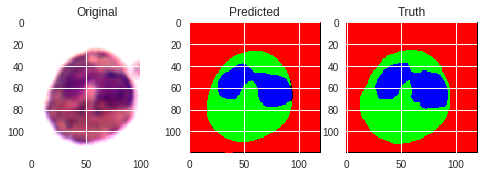

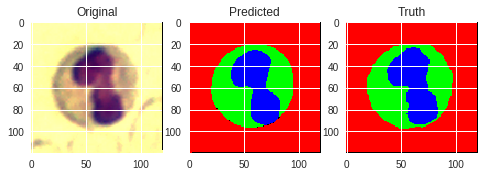

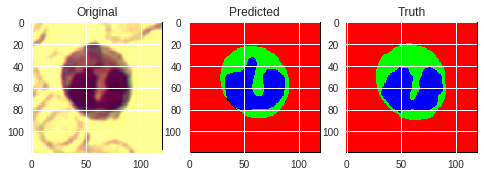

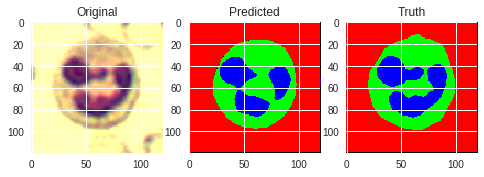

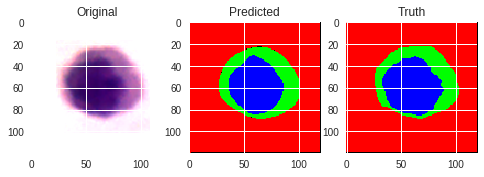

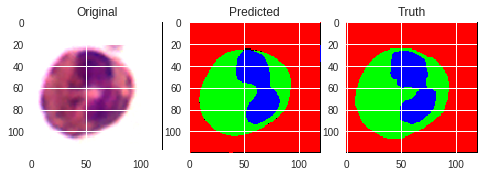

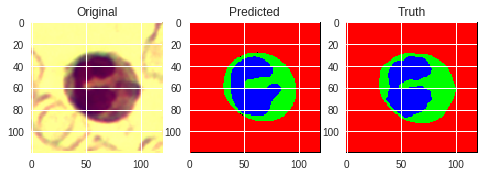

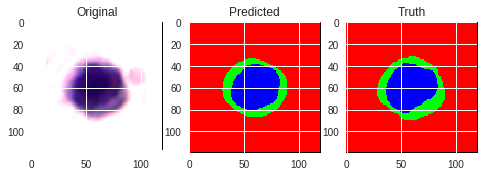

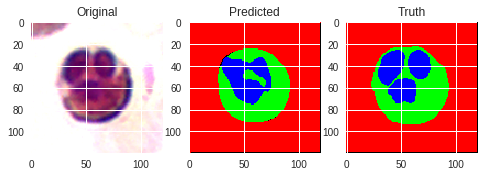

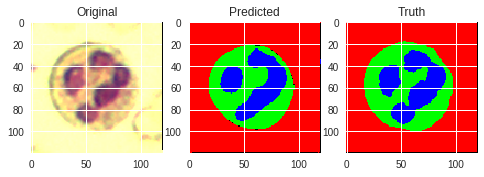

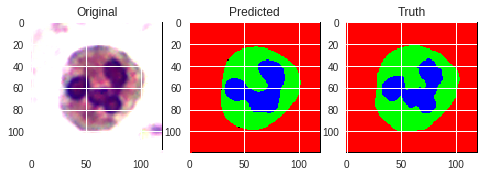

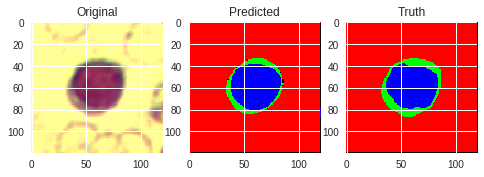

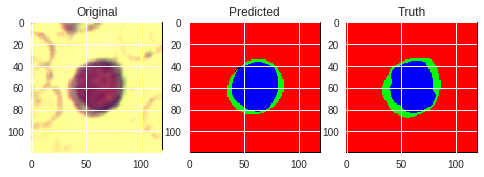

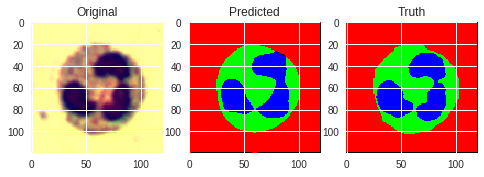

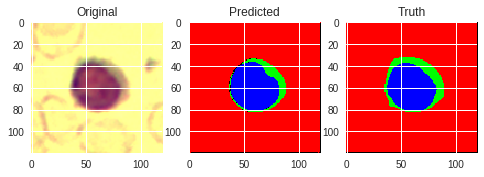

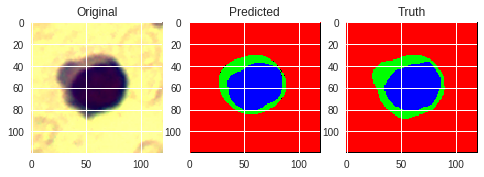

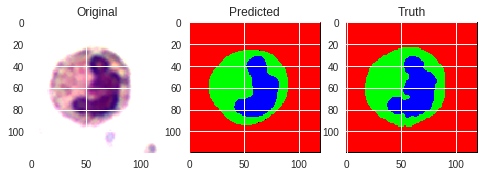

In [0]:
for i in range(30):
  fig = plt.figure()
  a=fig.add_subplot(1,3,1)
  plt.imshow(X_test[i])
  a.set_title('Original')
  a=fig.add_subplot(1,3,2)
  plt.imshow(p[i])
  a.set_title('Predicted')
  a=fig.add_subplot(1,3,3)
  plt.imshow(Y_test[i])
  a.set_title('Truth')
  plt.show()

Jaccard similarity

In [0]:
y_true = np.reshape(Y_test, (30, 3, 120*120))
y_pred = np.reshape(p, (30, 3, 120*120))

cyto = []
nucl = []

for i in range(30):
  print(i)
  print("cytoplasm similarity:")
  jac = jaccard_similarity_score(y_true[i][1], y_pred[i][1])
  cyto.append(jac)
  print(jac)
  print("nucleus similarity:")
  jac = jaccard_similarity_score(y_true[i][2], y_pred[i][2])
  nucl.append(jac)
  print(jac)

0
cytoplasm similarity:
0.9429166666666666
nucleus similarity:
0.9818055555555556
1
cytoplasm similarity:
0.9322916666666666
nucleus similarity:
0.9663194444444444
2
cytoplasm similarity:
0.9525
nucleus similarity:
0.9814583333333333
3
cytoplasm similarity:
0.9270833333333334
nucleus similarity:
0.9522222222222222
4
cytoplasm similarity:
0.9641666666666666
nucleus similarity:
0.9948611111111111
5
cytoplasm similarity:
0.9593055555555555
nucleus similarity:
0.985625
6
cytoplasm similarity:
0.9752083333333333
nucleus similarity:
0.9782638888888889
7
cytoplasm similarity:
0.9588888888888889
nucleus similarity:
0.9870833333333333
8
cytoplasm similarity:
0.9607638888888889
nucleus similarity:
0.9873611111111111
9
cytoplasm similarity:
0.9727777777777777
nucleus similarity:
0.99125
10
cytoplasm similarity:
0.9627777777777777
nucleus similarity:
0.9789583333333334
11
cytoplasm similarity:
0.9094444444444445
nucleus similarity:
0.94875
12
cytoplasm similarity:
0.9520138888888889
nucleus simila

In [0]:
m = np.array(cyto).mean()
s = np.array(cyto).std()
print("cytoplasm jaccard index mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))
m = np.array(nucl).mean()
s = np.array(nucl).std()
print("nucleus jaccard index mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))

cytoplasm jaccard index mean: 0.95335648 +/- 0.00270562
nucleus jaccard index mean: 0.98046528 +/- 0.00196231


Dice Similarity Coefficient

In [0]:
cyto = []
nucl = []

for i in range(30):
  print(i)
  print("cytoplasm similarity:")
  f1 = f1_score(y_true[i][1], y_pred[i][1], average='binary')
  cyto.append(f1)
  print(f1)
  print("nucleus similarity:")
  f1 = f1_score(y_true[i][2], y_pred[i][2], average='binary')
  nucl.append(f1)
  print(f1)

0
cytoplasm similarity:
0.9138003355704698
nucleus similarity:
0.9717733247145012
1
cytoplasm similarity:
0.8975086723431094
nucleus similarity:
0.9477427001400712
2
cytoplasm similarity:
0.9281512605042017
nucleus similarity:
0.97124394184168
3
cytoplasm similarity:
0.8897058823529411
nucleus similarity:
0.9258780435251025
4
cytoplasm similarity:
0.945798319327731
nucleus similarity:
0.9920275802628744
5
cytoplasm similarity:
0.9384712305753885
nucleus similarity:
0.9777011741893784
6
cytoplasm similarity:
0.9623774897249446
nucleus similarity:
0.9662751858635923
7
cytoplasm similarity:
0.9378151260504202
nucleus similarity:
0.9799655320982334
8
cytoplasm similarity:
0.9406325522748765
nucleus similarity:
0.9803794739111685
9
cytoplasm similarity:
0.9588235294117647
nucleus similarity:
0.9864282636794486
10
cytoplasm similarity:
0.9436974789915966
nucleus similarity:
0.9673456191399935
11
cytoplasm similarity:
0.8629964278209709
nucleus similarity:
0.9204741379310344
12
cytoplasm simi

In [0]:
m = np.array(cyto).mean()
s = np.array(cyto).std()
print("cytoplasm Dice Similarity Coefficient mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))
m = np.array(nucl).mean()
s = np.array(nucl).std()
print("nucleus Dice Similarity Coefficient mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))

cytoplasm Dice Similarity Coefficient mean: 0.92942281 +/- 0.0040905
nucleus Dice Similarity Coefficient mean: 0.96969616 +/- 0.00304442
